In [79]:
import time
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.0005)

In [1]:
class_mapping = {}
with open('dbpedia/dbpedia_csv/classes.txt') as txt_file:
    line_num = 1
    for line in txt_file:
        class_mapping[line_num-1] = line.strip()
        line_num+=1
        
print(class_mapping)

FileNotFoundError: [Errno 2] No such file or directory: 'CS291A/dbpedia_csv/classes.txt'

In [38]:
train_data = pd.read_csv('dbpedia/dbpedia_csv/train.csv', header = -1, names = ['ClassIndex', 'Title', 'Content'])
test_data = pd.read_csv('dbpedia/dbpedia_csv/test.csv', header = -1, names = ['ClassIndex', 'Title', 'Content'])

In [3]:
tempXtrain = train_data['Content'].tolist()
tempytrain = train_data['ClassIndex'].tolist()
Xtrain = []
ytrain = []
for i in range(14):
    Xtrain.extend(tempXtrain[i*40000:(i*40000+30000)])
    ytrain.extend(tempytrain[i*40000:(i*40000+30000)])
del train_data,tempXtrain,tempytrain

In [61]:
stemmer = PorterStemmer()

def process(data):
    processed = []
    for item in data:
        item = item.lower()
        item = word_tokenize(item)
        for word in item:
            if word in stopwords.words('english'):
                item.remove(word)
        for i in range(len(item)):
            item[i] = stemmer.stem(item[i])
        processed.append(' '.join(item))
    return processed

In [5]:
Xtrain = process(Xtrain)
test_data['ProcessedContent'] = process(test_data['Content'])

Elapsed Time: 96.62619079351425
Elapsed Time: 15.806128056844075


In [6]:
Xtest = test_data['ProcessedContent'].tolist()
ytest = test_data['ClassIndex'].tolist()
del test_data

In [7]:
Xtrain = vectorizer.fit_transform(Xtrain).toarray()
Xtest = vectorizer.transform(Xtest).toarray()

In [8]:
pkl.dump(vectorizer, open('TfIdfVectorizer', 'wb'))

In [22]:
import numpy as np
np.save(open('TfIdfTraining_data', 'wb'), Xtrain)

In [23]:
np.save(open('TfIdfTraining_labels', 'wb'), ytrain)
np.save(open('TfIdfTesting_data', 'wb'), Xtest)
np.save(open('TfIdfTesting_labels', 'wb'), ytest)

In [24]:
multinomialNB = MultinomialNB().fit(Xtrain,ytrain)

In [26]:
pkl.dump(multinomialNB, open('MultinomialNB', 'wb'))

In [25]:
predictions = multinomialNB.predict(Xtest)
accuracy = sum(predictions==ytest)/len(predictions)

## Sequential Testing

### First, create dataset

In [54]:
vectorizer = pkl.load(open('TfIdfVectorizer', 'rb'))

In [72]:
start = time.time()
accuracies = {}
for label in os.listdir('dbpedia/Testing'):
    accuracies[label] = {}
    for sent_len in os.listdir('dbpedia/Testing/{}/'.format(label)):
#         Xtest = np.empty((0,5187))
        Xtest = []
        labels = []
        if int(sent_len) <= 100:
            for file in os.listdir('dbpedia/Testing/{}/{}/'.format(label,sent_len)):
                sample = pkl.load(open('dbpedia/Testing/{}/{}/{}'.format(label,sent_len,file), 'rb'))
                labels.append(sample[0])
#                 Xtest = np.vstack((Xtest, sample[1]))
                Xtest.append(' '.join(process(sample[1])))
            Xtest = vectorizer.transform(Xtest).toarray()
            result = multinomialNB.predict(Xtest)
            accuracy = np.sum(result == labels)/len(labels)
            print('{}, sentence length: {}, Accuracy: {}'.format(label,sent_len,np.sum(result == labels)/len(labels)))
            accuracies[label][sent_len] = accuracy
    print('elapsed time: {}'.format((time.time()-start)/60))
pkl.dump(accuracies, open('dbpedia/TfIdfTesting/Accuracy', 'wb'))

Class1, sentence length: 1, Accuracy: 0.756
Class1, sentence length: 10, Accuracy: 0.7771979124849459
Class1, sentence length: 100, Accuracy: 0.75
Class1, sentence length: 11, Accuracy: 0.7942891614719485
Class1, sentence length: 12, Accuracy: 0.8071803146430012
Class1, sentence length: 13, Accuracy: 0.8222897669706181
Class1, sentence length: 14, Accuracy: 0.8307254623044097
Class1, sentence length: 15, Accuracy: 0.8318710467251581
Class1, sentence length: 16, Accuracy: 0.8371663244353182
Class1, sentence length: 17, Accuracy: 0.8413778877887789
Class1, sentence length: 18, Accuracy: 0.8490330630068621
Class1, sentence length: 19, Accuracy: 0.8516966904063679
Class1, sentence length: 2, Accuracy: 0.5756
Class1, sentence length: 20, Accuracy: 0.8525005275374552
Class1, sentence length: 21, Accuracy: 0.8547081380485726
Class1, sentence length: 22, Accuracy: 0.8521066208082545
Class1, sentence length: 23, Accuracy: 0.8552546045503792
Class1, sentence length: 24, Accuracy: 0.8532370953630

Class10, sentence length: 49, Accuracy: 0.8733233979135618
Class10, sentence length: 5, Accuracy: 0.5094
Class10, sentence length: 50, Accuracy: 0.8750957854406131
Class10, sentence length: 51, Accuracy: 0.8735271013354281
Class10, sentence length: 52, Accuracy: 0.8715670436187399
Class10, sentence length: 53, Accuracy: 0.8701406120760959
Class10, sentence length: 54, Accuracy: 0.8655172413793103
Class10, sentence length: 55, Accuracy: 0.8648888888888889
Class10, sentence length: 56, Accuracy: 0.8657534246575342
Class10, sentence length: 57, Accuracy: 0.8649669499527857
Class10, sentence length: 58, Accuracy: 0.87279843444227
Class10, sentence length: 59, Accuracy: 0.868020304568528
Class10, sentence length: 6, Accuracy: 0.5246
Class10, sentence length: 60, Accuracy: 0.8714436248682824
Class10, sentence length: 61, Accuracy: 0.8768898488120951
Class10, sentence length: 62, Accuracy: 0.8754134509371555
Class10, sentence length: 63, Accuracy: 0.8698630136986302
Class10, sentence length: 

Class11, sentence length: 87, Accuracy: 1.0
Class11, sentence length: 88, Accuracy: 1.0
Class11, sentence length: 89, Accuracy: 1.0
Class11, sentence length: 9, Accuracy: 0.862590799031477
Class11, sentence length: 90, Accuracy: 1.0
Class11, sentence length: 91, Accuracy: 1.0
Class11, sentence length: 92, Accuracy: 1.0
Class11, sentence length: 93, Accuracy: 1.0
Class11, sentence length: 94, Accuracy: 1.0
Class11, sentence length: 95, Accuracy: 1.0
Class11, sentence length: 96, Accuracy: 1.0
Class11, sentence length: 97, Accuracy: 1.0
Class11, sentence length: 98, Accuracy: 1.0
Class11, sentence length: 99, Accuracy: 1.0
elapsed time: 180.26760085026424
Class12, sentence length: 1, Accuracy: 0.1218
Class12, sentence length: 10, Accuracy: 0.8926995587645408
Class12, sentence length: 100, Accuracy: 0.972972972972973
Class12, sentence length: 11, Accuracy: 0.9122559871201449
Class12, sentence length: 12, Accuracy: 0.9239020441206234
Class12, sentence length: 13, Accuracy: 0.93211009174311

Class13, sentence length: 36, Accuracy: 0.9592021758839528
Class13, sentence length: 37, Accuracy: 0.9593220338983051
Class13, sentence length: 38, Accuracy: 0.9600251809883538
Class13, sentence length: 39, Accuracy: 0.9598070739549839
Class13, sentence length: 4, Accuracy: 0.2294
Class13, sentence length: 40, Accuracy: 0.9587291188994431
Class13, sentence length: 41, Accuracy: 0.9592518370073481
Class13, sentence length: 42, Accuracy: 0.9605039155600953
Class13, sentence length: 43, Accuracy: 0.9563547486033519
Class13, sentence length: 44, Accuracy: 0.9564748201438849
Class13, sentence length: 45, Accuracy: 0.9563448020717721
Class13, sentence length: 46, Accuracy: 0.9555471124620061
Class13, sentence length: 47, Accuracy: 0.9549864183158712
Class13, sentence length: 48, Accuracy: 0.956039603960396
Class13, sentence length: 49, Accuracy: 0.9560081466395112
Class13, sentence length: 5, Accuracy: 0.3292
Class13, sentence length: 50, Accuracy: 0.9531380753138076
Class13, sentence length

Class14, sentence length: 74, Accuracy: 0.916010498687664
Class14, sentence length: 75, Accuracy: 0.9183098591549296
Class14, sentence length: 76, Accuracy: 0.9200799200799201
Class14, sentence length: 77, Accuracy: 0.921505376344086
Class14, sentence length: 78, Accuracy: 0.9202813599062134
Class14, sentence length: 79, Accuracy: 0.9211886304909561
Class14, sentence length: 8, Accuracy: 0.6419283856771354
Class14, sentence length: 80, Accuracy: 0.9236209335219236
Class14, sentence length: 81, Accuracy: 0.9308176100628931
Class14, sentence length: 82, Accuracy: 0.9290657439446367
Class14, sentence length: 83, Accuracy: 0.9339805825242719
Class14, sentence length: 84, Accuracy: 0.9336384439359268
Class14, sentence length: 85, Accuracy: 0.9340369393139841
Class14, sentence length: 86, Accuracy: 0.9356913183279743
Class14, sentence length: 87, Accuracy: 0.9330855018587361
Class14, sentence length: 88, Accuracy: 0.9360730593607306
Class14, sentence length: 89, Accuracy: 0.9325842696629213


Class3, sentence length: 21, Accuracy: 0.8341168569509738
Class3, sentence length: 22, Accuracy: 0.8479836882646126
Class3, sentence length: 23, Accuracy: 0.8551123337918386
Class3, sentence length: 24, Accuracy: 0.856678281068525
Class3, sentence length: 25, Accuracy: 0.8571764705882353
Class3, sentence length: 26, Accuracy: 0.8611708482676225
Class3, sentence length: 27, Accuracy: 0.861810261374637
Class3, sentence length: 28, Accuracy: 0.8616290480863592
Class3, sentence length: 29, Accuracy: 0.8569651741293532
Class3, sentence length: 3, Accuracy: 0.0486
Class3, sentence length: 30, Accuracy: 0.8580465587044535
Class3, sentence length: 31, Accuracy: 0.8616529774127311
Class3, sentence length: 32, Accuracy: 0.8586332811684925
Class3, sentence length: 33, Accuracy: 0.8588453389830508
Class3, sentence length: 34, Accuracy: 0.8596821976838136
Class3, sentence length: 35, Accuracy: 0.8600054899807851
Class3, sentence length: 36, Accuracy: 0.8594489284720289
Class3, sentence length: 37, 

Class4, sentence length: 60, Accuracy: 0.9790486976217441
Class4, sentence length: 61, Accuracy: 0.9784382284382285
Class4, sentence length: 62, Accuracy: 0.9772318753744758
Class4, sentence length: 63, Accuracy: 0.9772587584511371
Class4, sentence length: 64, Accuracy: 0.9764780673871583
Class4, sentence length: 65, Accuracy: 0.9769736842105263
Class4, sentence length: 66, Accuracy: 0.976775956284153
Class4, sentence length: 67, Accuracy: 0.9779985805535841
Class4, sentence length: 68, Accuracy: 0.9785344189489267
Class4, sentence length: 69, Accuracy: 0.9785932721712538
Class4, sentence length: 7, Accuracy: 0.5945945945945946
Class4, sentence length: 70, Accuracy: 0.9793650793650793
Class4, sentence length: 71, Accuracy: 0.979253112033195
Class4, sentence length: 72, Accuracy: 0.9791485664639444
Class4, sentence length: 73, Accuracy: 0.9781021897810219
Class4, sentence length: 74, Accuracy: 0.9778846153846154
Class4, sentence length: 75, Accuracy: 0.9778002018163471
Class4, sentence 

Class6, sentence length: 1, Accuracy: 0.3234
Class6, sentence length: 10, Accuracy: 0.8839303582149289
Class6, sentence length: 100, Accuracy: 1.0
Class6, sentence length: 11, Accuracy: 0.9035035035035035
Class6, sentence length: 12, Accuracy: 0.9167836374573892
Class6, sentence length: 13, Accuracy: 0.9278826838087585
Class6, sentence length: 14, Accuracy: 0.9333467579540878
Class6, sentence length: 15, Accuracy: 0.9371717171717172
Class6, sentence length: 16, Accuracy: 0.9409616555082166
Class6, sentence length: 17, Accuracy: 0.9462826797385621
Class6, sentence length: 18, Accuracy: 0.9510791366906475
Class6, sentence length: 19, Accuracy: 0.9527950310559006
Class6, sentence length: 2, Accuracy: 0.4074
Class6, sentence length: 20, Accuracy: 0.9527394395650356
Class6, sentence length: 21, Accuracy: 0.952451394759087
Class6, sentence length: 22, Accuracy: 0.9546814878153057
Class6, sentence length: 23, Accuracy: 0.9559204840103717
Class6, sentence length: 24, Accuracy: 0.95684394071490

Class7, sentence length: 50, Accuracy: 0.9258511252163878
Class7, sentence length: 51, Accuracy: 0.9282996780801873
Class7, sentence length: 52, Accuracy: 0.9293413173652695
Class7, sentence length: 53, Accuracy: 0.9291603053435115
Class7, sentence length: 54, Accuracy: 0.9290603609209708
Class7, sentence length: 55, Accuracy: 0.9305863708399366
Class7, sentence length: 56, Accuracy: 0.9323186528497409
Class7, sentence length: 57, Accuracy: 0.9334877564526803
Class7, sentence length: 58, Accuracy: 0.9331750339213026
Class7, sentence length: 59, Accuracy: 0.9336592178770949
Class7, sentence length: 6, Accuracy: 0.7636
Class7, sentence length: 60, Accuracy: 0.9357142857142857
Class7, sentence length: 61, Accuracy: 0.9345760233918129
Class7, sentence length: 62, Accuracy: 0.9376652814506989
Class7, sentence length: 63, Accuracy: 0.9370847987495116
Class7, sentence length: 64, Accuracy: 0.936770036246476
Class7, sentence length: 65, Accuracy: 0.9368508516825924
Class7, sentence length: 66,

Class8, sentence length: 91, Accuracy: 0.9783549783549783
Class8, sentence length: 92, Accuracy: 0.9844559585492227
Class8, sentence length: 93, Accuracy: 0.9802631578947368
Class8, sentence length: 94, Accuracy: 0.9919354838709677
Class8, sentence length: 95, Accuracy: 0.9904761904761905
Class8, sentence length: 96, Accuracy: 1.0
Class8, sentence length: 97, Accuracy: 1.0
Class8, sentence length: 98, Accuracy: 1.0
Class8, sentence length: 99, Accuracy: 1.0
elapsed time: 963.2837941328685
Class9, sentence length: 1, Accuracy: 0.0276
Class9, sentence length: 10, Accuracy: 0.9112854556427278
Class9, sentence length: 11, Accuracy: 0.9202577527184858
Class9, sentence length: 12, Accuracy: 0.9453109175612721
Class9, sentence length: 13, Accuracy: 0.9571138211382114
Class9, sentence length: 14, Accuracy: 0.9583597548087085
Class9, sentence length: 15, Accuracy: 0.9605065464691994
Class9, sentence length: 16, Accuracy: 0.9628154050464808
Class9, sentence length: 17, Accuracy: 0.96615108720017

In [73]:
accs = pkl.load(open('dbpedia/TfIdfTesting/Accuracy', 'rb'))

In [74]:
for key1 in accs.keys():
    for key2 in accs[key1].keys():
        print("{}:\tSentence length: {}\tAccuracy: {}".format(key1,key2,accs[key1][key2]))

Class1:	Sentence length: 1	Accuracy: 0.756
Class1:	Sentence length: 10	Accuracy: 0.7771979124849459
Class1:	Sentence length: 100	Accuracy: 0.75
Class1:	Sentence length: 11	Accuracy: 0.7942891614719485
Class1:	Sentence length: 12	Accuracy: 0.8071803146430012
Class1:	Sentence length: 13	Accuracy: 0.8222897669706181
Class1:	Sentence length: 14	Accuracy: 0.8307254623044097
Class1:	Sentence length: 15	Accuracy: 0.8318710467251581
Class1:	Sentence length: 16	Accuracy: 0.8371663244353182
Class1:	Sentence length: 17	Accuracy: 0.8413778877887789
Class1:	Sentence length: 18	Accuracy: 0.8490330630068621
Class1:	Sentence length: 19	Accuracy: 0.8516966904063679
Class1:	Sentence length: 2	Accuracy: 0.5756
Class1:	Sentence length: 20	Accuracy: 0.8525005275374552
Class1:	Sentence length: 21	Accuracy: 0.8547081380485726
Class1:	Sentence length: 22	Accuracy: 0.8521066208082545
Class1:	Sentence length: 23	Accuracy: 0.8552546045503792
Class1:	Sentence length: 24	Accuracy: 0.8532370953630796
Class1:	Senten

In [77]:
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns), key = int), axis = 1).transpose()
accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)
accuracies

,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork,Total Accuracy,Number of Words
1,0.756000,0.018000,0.075000,0.121800,0.077800,0.053800,0.051400,0.022800,0.039800,0.158600,0.323400,0.119200,0.101800,0.027600,0.139071,1
2,0.575600,0.048000,0.091200,0.190800,0.140800,0.150600,0.459800,0.029200,0.049200,0.167800,0.407400,0.365400,0.345200,0.064800,0.220414,2
3,0.605600,0.066600,0.170800,0.230600,0.180600,0.220000,0.717800,0.048600,0.053000,0.171400,0.502200,0.544600,0.630000,0.300200,0.317286,3
4,0.569514,0.299600,0.239600,0.374075,0.229400,0.292600,0.842137,0.155925,0.308585,0.234047,0.544800,0.653200,0.759800,0.609800,0.436649,4
5,0.609209,0.509400,0.674935,0.512903,0.329200,0.389600,0.878151,0.225781,0.482089,0.375475,0.603800,0.719000,0.826200,0.669400,0.557510,5
6,0.655918,0.524600,0.811762,0.651930,0.460800,0.498000,0.894958,0.272618,0.558735,0.489694,0.687800,0.763600,0.860400,0.678200,0.629215,6
7,0.700060,0.740000,0.850170,0.763953,0.588789,0.588200,0.907545,0.274219,0.594595,0.594557,0.763200,0.805200,0.891200,0.846000,0.707692,7
8,0.729058,0.774775,0.843825,0.830732,0.690858,0.641928,0.916950,0.282992,0.632432,0.654123,0.816800,0.832000,0.895570,0.860805,0.743061,8
9,0.750551,0.801769,0.862591,0.871220,0.754418,0.685760,0.925555,0.313643,0.654578,0.677891,0.857371,0.849370,0.907039,0.906482,0.772731,9
10,0.777198,0.837679,0.880678,0.892700,0.787775,0.723114,0.932560,0.353368,0.669073,0.699940,0.883930,0.860101,0.916173,0.911285,0.794684,10


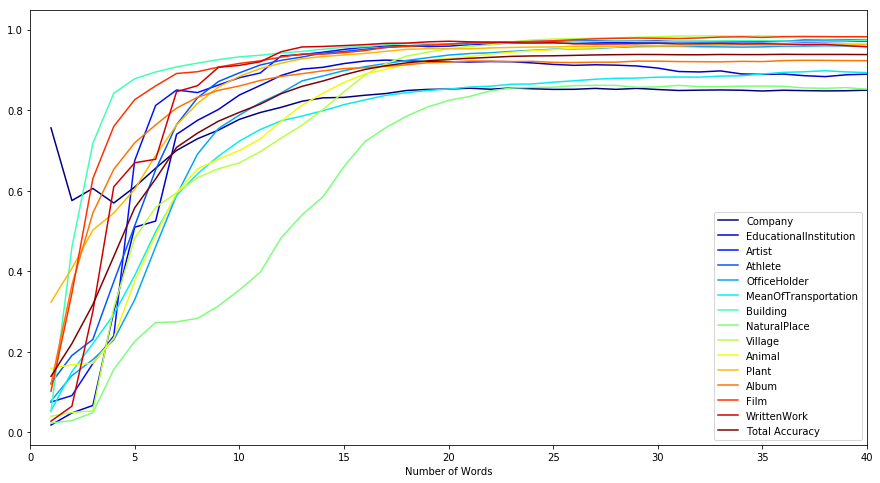

In [80]:
accuracies.plot(x ='Number of Words', figsize = (15,8), xlim=(0,40), colormap = 'jet')
plt.show()

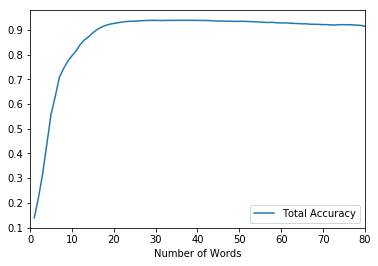

In [81]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy', xlim=(0,80))
plt.show()